<a href="https://colab.research.google.com/github/kevinracso/Tarea_Intel_01/blob/master/Tarea1_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1: Perceptrón Multicapa
### EL4106 Inteligencia Computacional

Profesor de Cátedra: Pablo Estévez<br>
Profesor Auxiliar: Ignacio Reyes<br>
Ayudantes: Germán García, Esteban Reyes, Mauricio Romero, Nicolás Tapia, Miguel Videla

## Imports

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import itertools
from sklearn.metrics import confusion_matrix as sk_conf_mat

## Preparación de la base de datos MNIST

In [0]:
# ----- Digito a identificar.
RUT_veri_number = 8

In [0]:
def process_dataset(images, labels, selected_class):
    """Revuelve datos y selecciona subconjunto segun la clase seleccionada.
    
    Los datos de imagenes y etiquetas son revueltos, se seleccionan aquellos
    que coinciden con la etiqueta de la clase seleccionada, y un subconjunto
    del mismo tamaño que el anterior es seleccionado de entre todas las demas
    clases para obtener un problema balanceado.
    """
    shuffled_indexes = np.random.permutation(len(labels))  # Primer shuffle
    images = images[shuffled_indexes]
    labels = labels[shuffled_indexes]
    selected_column = labels[:, selected_class]
    selected_images_indexes = np.where(selected_column == 1)[0]
    selected_size = len(selected_images_indexes)
    non_selected_indexes_subset = np.where(selected_column == 0)[0][:selected_size]
    indexes = np.concatenate(
        (selected_images_indexes, 
        non_selected_indexes_subset),
        axis=0)
    # No queremos que el modelo primero vea todos los datos de una clase y
    # despues todos los de la otra, asi que volvemos a revolver.
    np.random.shuffle(indexes)
    images_subset = images[indexes]
    labels_subset = selected_column[indexes]
    labels_subset = np.array(labels_subset, dtype=np.int32)
    return images_subset, labels_subset


# ----- Carga de la base de datos MNIST
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)  

# ----- Preprocesamiento de datos de entrenamiento, validacion, y test
training_images, training_labels = process_dataset(
    mnist.train.images,
    mnist.train.labels,
    RUT_veri_number)
validation_images, validation_labels = process_dataset(
    mnist.validation.images,
    mnist.validation.labels,
    RUT_veri_number)
testing_images, testing_labels = process_dataset(
    mnist.test.images,
    mnist.test.labels,
    RUT_veri_number)
print('Processing ready.')

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Processing ready.


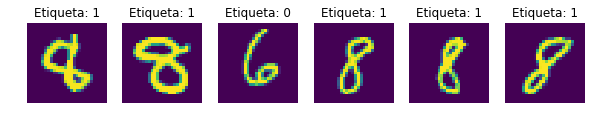

In [0]:
# ----- Visualizacion de algunas imagenes de los datos de entrenamiento

chosen_idx = np.random.choice(training_images.shape[0], size=6, replace=False)

fig, ax = plt.subplots(1, 6, figsize=(10,5))
for i, idx in enumerate(chosen_idx):
    image = training_images[idx, :]
    digit = training_labels[idx]
    ax[i].imshow(image.reshape((28, 28)))
    ax[i].set_title("Etiqueta: %d" % digit)
    ax[i].axis('off')

## Definición de Clasificador MLP

### Función del modelo de red neuronal 

In [0]:
def model_fn(inputs, layer_sizes):
    """Construye el grafo computacional de la red MLP.
    
    Se procesa 'inputs' a través de un perceptron multicapa, cuya salida se
    retorna en forma de logits y probabilidades de cada clase.
    Summaries son agregados para su visualizacion en Tensorboard.
    
    Args:
        inputs: Tensor de entrada de dimensiones (batch_size, n_features).
        layer_sizes: Lista de enteros que indica el tamaño de cada capa de
            neuronas. La salida de la capa i-esima posee dimensiones
            (batch_size, layer_sizes[i]). El ultimo numero de la lista indica el
            tamaño de la capa de salida, que debe ser igual al numero de clases.
    
    Returns:
        logits: Tensor de salida lineal de dimensiones (batch_size, n_classes).
        probabilities: Tensor de salida con activacion softmax.
    """

    layer = inputs
    n_layers = len(layer_sizes)   
    # Capas neuronales
    for i in range(n_layers):
        with tf.variable_scope('layer_'+str(i)):          
            previous_size = layer.shape[1].value  # Tamaño de entrada a la capa          
            # Pesos de la capa oculta i-esima
            weights = tf.get_variable(
                name='weights_'+str(i),
                shape=[previous_size, layer_sizes[i]],
                initializer=tf.glorot_uniform_initializer())
            # Summary de la distribucion de los pesos
            tf.summary.histogram('weights_'+str(i), weights)

            # Sesgos de la capa oculta i-esima
            biases = tf.get_variable(
                name='biases_'+str(i),
                shape=[layer_sizes[i]],
                initializer=tf.zeros_initializer())
            # Summary de la distribucion de los sesgos
            tf.summary.histogram('biases_'+str(i), biases)
            # Aplicacion de pesos y sesgos
            layer = tf.matmul(layer, weights) + biases          
            if i < n_layers - 1:
                # Aplicacion de funcion de activacion de capa oculta
                layer = tf.nn.sigmoid(layer)
            else:
                # Aplicacion de funcion de activacion de capa de salida
                logits = layer
                probabilities = tf.nn.softmax(logits)   
    return logits, probabilities

### Función de costo

In [0]:
def loss_fn(logits, labels, loss_function_name):
    """Construye el grafo computacional del calculo de la funcion de costo.
    
    Se aplica el loss 'loss_function_name' entre los labels reales y la salida
    de la MLP. Ademas, se calcula el accuracy.
    Summaries son agregados para su visualizacion en Tensorboard.
    
    Args:
        logits: Tensor de dimensiones (batch_size, n_classes) con los logits
        de la salida de la MLP
        labels: Tensor de dimensiones (batch_size,) con las etiquetas reales.
        loss_function_name: 'cross_entropy' o 'mse', selecciona el costo.
    
    Returns:
        loss: Tensor escalar que corresponde al costo calculado.
        accuracy: Tensor escalar que corresponde al accuracy calculado.
        val_summaries: summaries que son de interes al predecir en la validacion
    """
    
    # Codificacion 'one hot' para las etiquetas de clase
    n_classes = logits.shape[1].value
    one_hot_labels = tf.one_hot(labels, n_classes)
    val_summaries = []
    with tf.variable_scope('loss'):
        if loss_function_name == 'cross_entropy':
            # Cross Entropy loss
            loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits_v2(
                    logits=logits,
                    labels=one_hot_labels),
                name='xentropy'
            )
            # Summary de loss
            loss_sum = tf.summary.scalar('xentropy_loss', loss)
        elif loss_function_name == 'mse':
            # Mean Squared Error loss
            probabilities = tf.nn.softmax(logits)
            loss = tf.reduce_mean(
                tf.square(one_hot_labels - probabilities),
                name='mse'
            )
            # Summary de loss
            loss_sum = tf.summary.scalar('mse_loss', loss)
        else:
            raise ValueError('Wrong value for loss_function_name')
    val_summaries.append(loss_sum)
    with tf.variable_scope('accuracy'):
        predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
        correct_predictions = tf.equal(labels, predictions)
        accuracy = tf.reduce_mean(
            tf.cast(correct_predictions, tf.float32),
            name='accuracy')
        # Summary de accuracy
        acc_sum = tf.summary.scalar('accuracy', accuracy)
    val_summaries.append(acc_sum)
    return loss, accuracy, val_summaries

### Función del optimizador

In [0]:
def optimizer_fn(loss, learning_rate):
    """Construye el grafo computacional de la actualizacion por gradiente.
    
    Se aplica el algoritmo de optimizacion 'sgd' para ejecutar una
    iteracion de minimizacion por gradiente sobre el loss entregado.
    
    Args:
        loss: Tensor escalar que corresponde al costo calculado.
        learning_rate: Escalar que indica la tasa de aprendizaje. Al seleccionar
            Adam este parametro es ignorado.
        optimizer_name: 'sgd' o 'adam', selecciona el optimizador.
    
    Returns:
        train_step: Operacion que ejecuta una iteracion de gradiente.
    """
    
    with tf.variable_scope('optimizer'):
        # Gradient Descent
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        # Minimizacion de la funcion de costo con el optimizador elegido
        train_step = optimizer.minimize(loss)
    return train_step

### Clase de Clasificador MLP
Esta clase utiliza las funciones anteriores para la construcción del grafo computacional.

In [0]:
class MLPClassifier(object):
    """Implementacion de clasificador Perceptron Multicapa.
    """
    
    def __init__(
        self,
        n_features,
        layer_sizes,
        loss_function_name='cross_entropy',
        learning_rate=0.1,
        batch_size=32,
        max_epochs=100,
        early_stopping=None,
        logdir='logs'
    ):
        """Construye un clasificador Perceptron Multicapa.
        
        Args:
            n_features: Entero que indica el numero de caracteristicas de las entradas.
            layer_sizes: Lista de enteros que indica el tamaño de cada capa de
            neuronas. La salida de la capa i-esima posee dimensiones
            (batch_size, layer_sizes[i]). El ultimo numero de la lista indica el
            tamaño de la capa de salida, que debe ser igual al numero de clases.
            loss_function_name: 'cross_entropy' o 'mse', selecciona el costo.
                Por defecto es 'cross_entropy'.
            learning_rate: Escalar que indica la tasa de aprendizaje. Al
                seleccionar Adam este parametro es ignorado. Por defecto es 0.1
            batch_size: Entero que indica el tamaño de los mini-batches para
                el entrenamiento de la red.
            max_epochs: Entero que indica el maximo numero de epocas de
                entrenamiento (pasadas completas por los datos de entrada) 
            early_stopping: Indica cuantas veces las verificaciones en la
                validacion deben indicar que el costo esta aumentando para
                realizar una detencion temprana. Por defecto es None, lo cual
                desactiva la detencion temprana.
            logdir: String que indica el directorio en donde guardar los
                archivos del entrenamiento. Por defecto es 'logs'.
        """
        
        # Limpiar grafo computacional
        tf.reset_default_graph()
        # Agregar parametros al objeto
        self.n_features = n_features
        self.layer_sizes = layer_sizes
        self.loss_function_name = loss_function_name
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.early_stopping = early_stopping
        self.logdir = logdir
        # Tensor que reserva espacio para las imagenes de entrada a la red
        self.inputs_ph = tf.placeholder(tf.float32, shape=[None, n_features],
                                   name='image_placeholder')
        # Tensor que reserva espacio para las etiquetas de la entrada
        self.labels_ph = tf.placeholder(tf.int32, shape=None,
                                        name='label_placeholder')
        # Construccion del grafo computacional
        self.logits, self.proba = model_fn(
            self.inputs_ph, layer_sizes)
        self.loss, self.accuracy, self.val_summ = loss_fn(
            self.logits, self.labels_ph, loss_function_name)
        self.train_step = optimizer_fn(
            self.loss, learning_rate)
        # Fusion de todos los summaries
        self.summ = tf.summary.merge_all()
        self.val_summ = tf.summary.merge(self.val_summ)
        # Crear sesion de tensorflow para administrar grafo
        self.sess = tf.Session()
        
    def fit(self, X_train, y_train, X_val, y_val):
        """Entrenamiento del clasificador con los hiperparametros escogidos.
        
        Args:
            X_train: Entradas del entrenamiento con dimensiones (n_ejemplos, n_features).
            y_train: Etiquetas del entrenamiento con dimensiones (n_ejemplos,)
            X_val: Entradas de la validacion con dimensiones (n_ejemplos, n_features).
            y_val: Etiquetas de la validacion con dimensiones (n_ejemplos,)
            
        Returns:
            train_stats: Diccionario con datos historicos del entrenamiento.
        """
        
        # Creacion de 'writers' que guardan datos para Tensorboard
        writer_train = tf.summary.FileWriter(self.logdir + '/train')
        writer_val = tf.summary.FileWriter(self.logdir + '/val')
        writer_train.add_graph(self.sess.graph)
        print('\n\n[Beginning training of MLP at logdir "%s"]\n' % (self.logdir,))    
        # Inicializacion de todas las variables
        self.sess.run(tf.global_variables_initializer())     
        # Definicion de variables utiles para el entrenamiento
        n_batches = int(X_train.shape[0] / self.batch_size)
        prev_validation_loss = 100.0
        validation_period = 10
        early_stop_flag = False
        start_time = time.time()
        iteration_history = []
        train_loss_history = []
        train_acc_history = []
        val_loss_history = []
        val_acc_history = []
        
        # Ciclo que recorre una epoca completa de los datos cada vez
        for epoch in range(self.max_epochs):
            if early_stop_flag:
                # Si early stopping se activo, detener el entrenamiento
                break
            # Para cada nueva epoca, hacer un shuffle al set de train
            new_indexes = np.random.permutation(X_train.shape[0])
            X_train = X_train[new_indexes, :]
            y_train = y_train[new_indexes]
            
            # Ciclo que recorre los mini batches del set de train
            for i in range(n_batches):
                if early_stop_flag:
                    # Si early stopping se activo, detener el entrenamiento
                    break  
                iteration = epoch * n_batches + i           
                # Obtencion del minibatch actual
                start = i * self.batch_size
                end = (i+1) * self.batch_size
                X_batch = X_train[start:end, :]
                y_batch = y_train[start:end]          
                # Ejecutar una iteracion de gradiente
                feed_dict = {self.inputs_ph: X_batch, self.labels_ph: y_batch}
                self.sess.run(self.train_step, feed_dict=feed_dict)
                # Obtener estadisticas del entrenamiento
                if iteration % validation_period == 0:
                    iteration_history.append(iteration)
                    # Estadisticas en el set de validacion
                    feed_dict = {self.inputs_ph: X_val, self.labels_ph: y_val}
                    val_loss, val_acc, val_summ = self.sess.run(
                        [self.loss, self.accuracy, self.val_summ],
                        feed_dict=feed_dict)
                    writer_val.add_summary(val_summ, iteration)
                    val_loss_history.append(val_loss)
                    val_acc_history.append(val_acc)
                    # Estadisticas en el set de entrenamiento
                    feed_dict = {self.inputs_ph: X_train, self.labels_ph: y_train}
                    train_loss, train_acc, train_summ = self.sess.run(
                        [self.loss, self.accuracy, self.summ],
                        feed_dict=feed_dict)
                    writer_train.add_summary(train_summ, iteration)
                    train_loss_history.append(train_loss)
                    train_acc_history.append(train_acc)
                    
                    print('Epoch: %d/%d, iter: %d. ' %
                          (epoch+1, self.max_epochs, iteration), end='')
                    print('Loss (train/val): %.3f / %.3f. Val. acc: %.1f%%' %
                          (train_loss, val_loss, val_acc * 100), end='')
                    
                    # Chequear condicion de early_stopping
                    if self.early_stopping is not None:
                        if val_loss > prev_validation_loss:
                            validation_checks += 1
                        else:
                            validation_checks = 0
                            prev_validation_loss = val_loss
                        print(', Val. checks: %d/%d' %
                              (validation_checks, self.early_stopping))
                        if validation_checks >= self.early_stopping:
                            early_stop_flag = True
                            print('Early stopping')
                    else:
                        print('')
            elap_time = time.time()-start_time
            print("Epoch finished. Elapsed time %1.4f [s]\n" % (elap_time,))
        writer_train.flush()
        writer_val.flush()
        # Guardar estadisticas en un diccionario
        train_stats = {
            'iteration_history': np.array(iteration_history),
            'train_loss_history': np.array(train_loss_history),
            'train_acc_history': np.array(train_acc_history),
            'val_loss_history': np.array(val_loss_history),
            'val_acc_history': np.array(val_acc_history)
        }
        return train_stats
    
    def predict_proba(self, X):
        """Retorna las probabilidades de clase para los datos de entrada.
        """
        # Obtener las probabilidades de salida de cada clase
        predicted_proba = self.sess.run(self.proba, feed_dict={self.inputs_ph: X})
        return predicted_proba
    
    def predict_label(self, X):
        """Retorna la etiqueta predicha para los datos de entrada.
        """
        # Obtener la probabilidad de cada clase
        predicted_proba = self.predict_proba(X)
        # Etiquetar segun la etiqueta mas probable
        predicted_labels = np.argmax(predicted_proba, axis=1)
        return predicted_labels

## Entrenamiento de MLP

In [0]:
# ----- Directorio para logs
experiment_name = "exp_xentropy"

# --- NO TOCAR
logdir_father = "./tarea_1_logs/"
logdir = logdir_father + experiment_name

In [0]:
# ----- Ejecutar si es que se quiere un directorio limpio en logdir
# Si existe el directorio, ejecutar esta celda movera los archivos a otra
# carpeta para limpiar el logdir elegido.

%%bash -s "$logdir"
if [ -d $1 ]; then
    this_date="$(date "+%H%M%S-%y%m%d")"
    new_dir="$1_old_$this_date"
    echo "moving files from $1 to $new_dir"
    mv $1 $new_dir
fi

In [36]:
# Aqui se modifican parametros

run_n_times = 5
stats_history = []
stats_history_ce = []
stats_history_mse = []


for run in range(run_n_times):
    # ----- Creacion de MLP
    mlp = MLPClassifier(
        n_features=28*28,
        layer_sizes=[25, 2],
        loss_function_name='cross_entropy',
        learning_rate=10.,
        batch_size=32,
        max_epochs=100,
        early_stopping=15,
        logdir=logdir+'run_%d' % run)

    # ----- Entrenamiento de MLP
    train_stats = mlp.fit(training_images, training_labels, validation_images, validation_labels)
    stats_history.append(train_stats)
    
    #train_stats_01 = train_stats
    #train_stats_001 = train_stats
    #train_stats_1 = train_stats
    train_stats_10 = train_stats
    
    #train_stats_ce = train_stats
    #stats_history_ce.append(train_stats)
    
    #train_stats_mse = train_stats
    #stats_history_mse.append(train_stats)



[Beginning training of MLP at logdir "./tarea_1_logs/exp_xentropyrun_0"]

Epoch: 1/100, iter: 0. Loss (train/val): 5.456 / 5.452. Val. acc: 50.0%, Val. checks: 0/15
Epoch: 1/100, iter: 10. Loss (train/val): 5.947 / 5.908. Val. acc: 50.0%, Val. checks: 1/15
Epoch: 1/100, iter: 20. Loss (train/val): 2.016 / 2.015. Val. acc: 50.0%, Val. checks: 0/15
Epoch: 1/100, iter: 30. Loss (train/val): 0.699 / 0.700. Val. acc: 52.1%, Val. checks: 0/15
Epoch: 1/100, iter: 40. Loss (train/val): 4.132 / 4.165. Val. acc: 50.0%, Val. checks: 1/15
Epoch: 1/100, iter: 50. Loss (train/val): 3.610 / 3.635. Val. acc: 50.0%, Val. checks: 2/15
Epoch: 1/100, iter: 60. Loss (train/val): 1.770 / 1.752. Val. acc: 50.0%, Val. checks: 3/15
Epoch: 1/100, iter: 70. Loss (train/val): 1.375 / 1.314. Val. acc: 50.0%, Val. checks: 4/15
Epoch: 1/100, iter: 80. Loss (train/val): 1.002 / 0.982. Val. acc: 50.0%, Val. checks: 5/15
Epoch: 1/100, iter: 90. Loss (train/val): 1.682 / 1.674. Val. acc: 50.0%, Val. checks: 6/15
Epoch

### Tasa de acierto en validación computada sobre varias ejecuciones.

In [37]:
val_acc_history = np.array([run['val_acc_history'][-1] for run in stats_history])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print('Validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))
print(val_acc_history)

train_acc_history = np.array([run['train_acc_history'][-1] for run in stats_history])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print('Train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print(train_acc_history)

Validation accuracy 0.500 +/- 0.000
[0.5 0.5 0.5 0.5 0.5]
Train accuracy 0.500 +/- 0.000
[0.5 0.5 0.5 0.5 0.5]


## Visualización de Resultados

### Algunas estadísticas del entrenamiento

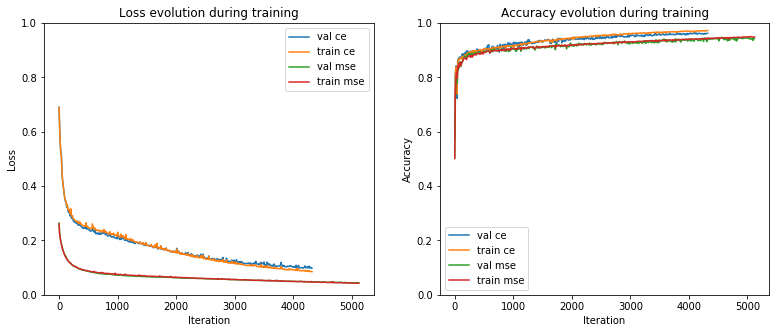

In [0]:
#train_stats = train_stats_ce
#train_stats = train_stats_mse


fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].plot(train_stats_ce['iteration_history'], train_stats_ce['val_loss_history'], label='val ce')
ax[0].plot(train_stats_ce['iteration_history'], train_stats_ce['train_loss_history'], label='train ce')
ax[0].plot(train_stats_mse['iteration_history'], train_stats_mse['val_loss_history'], label='val mse')
ax[0].plot(train_stats_mse['iteration_history'], train_stats_mse['train_loss_history'], label='train mse')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss evolution during training')
ax[0].set_ylim(0,1)
ax[0].legend()

ax[1].plot(train_stats_ce['iteration_history'], train_stats_ce['val_acc_history'], label='val ce')
ax[1].plot(train_stats_ce['iteration_history'], train_stats_ce['train_acc_history'], label='train ce')
ax[1].plot(train_stats_mse['iteration_history'], train_stats_mse['val_acc_history'], label='val mse')
ax[1].plot(train_stats_mse['iteration_history'], train_stats_mse['train_acc_history'], label='train mse')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy evolution during training')
ax[1].set_ylim(0,1)
ax[1].legend()

### Tasa de aprendizaje

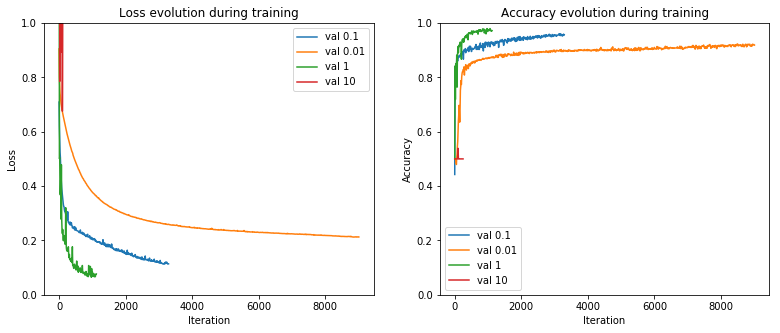

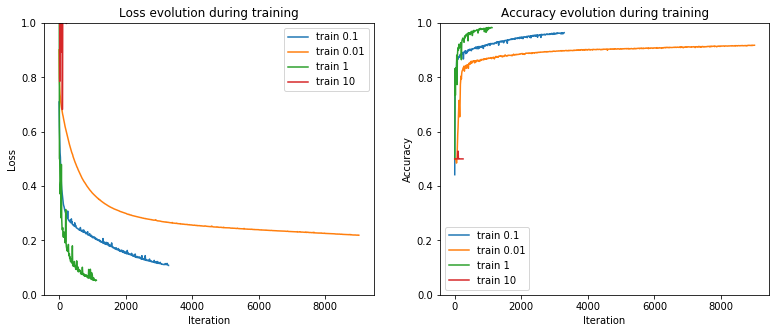

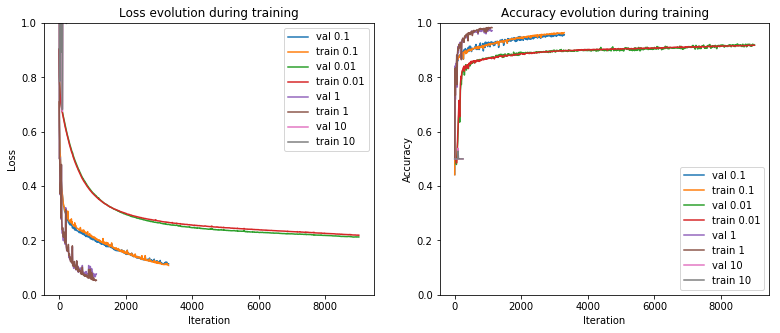

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5)) # solo val

ax[0].plot(train_stats_01['iteration_history'], train_stats_01['val_loss_history'], label='val 0.1')
#ax[0].plot(train_stats_01['iteration_history'], train_stats_01['train_loss_history'], label='train 0.1')
ax[0].plot(train_stats_001['iteration_history'], train_stats_001['val_loss_history'], label='val 0.01')
#ax[0].plot(train_stats_001['iteration_history'], train_stats_001['train_loss_history'], label='train 0.01')
ax[0].plot(train_stats_1['iteration_history'], train_stats_1['val_loss_history'], label='val 1')
#ax[0].plot(train_stats_1['iteration_history'], train_stats_1['train_loss_history'], label='train 1')
ax[0].plot(train_stats_10['iteration_history'], train_stats_10['val_loss_history'], label='val 10')
#ax[0].plot(train_stats_10['iteration_history'], train_stats_10['train_loss_history'], label='train 10')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss evolution during training')
ax[0].set_ylim(0,1)
ax[0].legend()

ax[1].plot(train_stats_01['iteration_history'], train_stats_01['val_acc_history'], label='val 0.1')
#ax[1].plot(train_stats_01['iteration_history'], train_stats_01['train_acc_history'], label='train 0.1')
ax[1].plot(train_stats_001['iteration_history'], train_stats_001['val_acc_history'], label='val 0.01')
#ax[1].plot(train_stats_001['iteration_history'], train_stats_001['train_acc_history'], label='train 0.01')
ax[1].plot(train_stats_1['iteration_history'], train_stats_1['val_acc_history'], label='val 1')
#ax[1].plot(train_stats_1['iteration_history'], train_stats_1['train_acc_history'], label='train 1')
ax[1].plot(train_stats_10['iteration_history'], train_stats_10['val_acc_history'], label='val 10')
#ax[1].plot(train_stats_10['iteration_history'], train_stats_10['train_acc_history'], label='train 10')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy evolution during training')
ax[1].set_ylim(0,1)
ax[1].legend()

fig, ax = plt.subplots(1, 2, figsize=(13, 5)) # solo train

#ax[0].plot(train_stats_01['iteration_history'], train_stats_01['val_loss_history'], label='val 0.1')
ax[0].plot(train_stats_01['iteration_history'], train_stats_01['train_loss_history'], label='train 0.1')
#ax[0].plot(train_stats_001['iteration_history'], train_stats_001['val_loss_history'], label='val 0.01')
ax[0].plot(train_stats_001['iteration_history'], train_stats_001['train_loss_history'], label='train 0.01')
#ax[0].plot(train_stats_1['iteration_history'], train_stats_1['val_loss_history'], label='val 1')
ax[0].plot(train_stats_1['iteration_history'], train_stats_1['train_loss_history'], label='train 1')
#ax[0].plot(train_stats_10['iteration_history'], train_stats_10['val_loss_history'], label='val 10')
ax[0].plot(train_stats_10['iteration_history'], train_stats_10['train_loss_history'], label='train 10')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss evolution during training')
ax[0].set_ylim(0,1)
ax[0].legend()

#ax[1].plot(train_stats_01['iteration_history'], train_stats_01['val_acc_history'], label='val 0.1')
ax[1].plot(train_stats_01['iteration_history'], train_stats_01['train_acc_history'], label='train 0.1')
#ax[1].plot(train_stats_001['iteration_history'], train_stats_001['val_acc_history'], label='val 0.01')
ax[1].plot(train_stats_001['iteration_history'], train_stats_001['train_acc_history'], label='train 0.01')
#ax[1].plot(train_stats_1['iteration_history'], train_stats_1['val_acc_history'], label='val 1')
ax[1].plot(train_stats_1['iteration_history'], train_stats_1['train_acc_history'], label='train 1')
#ax[1].plot(train_stats_10['iteration_history'], train_stats_10['val_acc_history'], label='val 10')
ax[1].plot(train_stats_10['iteration_history'], train_stats_10['train_acc_history'], label='train 10')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy evolution during training')
ax[1].set_ylim(0,1)
ax[1].legend()

fig, ax = plt.subplots(1, 2, figsize=(13, 5)) # val y train

ax[0].plot(train_stats_01['iteration_history'], train_stats_01['val_loss_history'], label='val 0.1')
ax[0].plot(train_stats_01['iteration_history'], train_stats_01['train_loss_history'], label='train 0.1')
ax[0].plot(train_stats_001['iteration_history'], train_stats_001['val_loss_history'], label='val 0.01')
ax[0].plot(train_stats_001['iteration_history'], train_stats_001['train_loss_history'], label='train 0.01')
ax[0].plot(train_stats_1['iteration_history'], train_stats_1['val_loss_history'], label='val 1')
ax[0].plot(train_stats_1['iteration_history'], train_stats_1['train_loss_history'], label='train 1')
ax[0].plot(train_stats_10['iteration_history'], train_stats_10['val_loss_history'], label='val 10')
ax[0].plot(train_stats_10['iteration_history'], train_stats_10['train_loss_history'], label='train 10')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss evolution during training')
ax[0].set_ylim(0,1)
ax[0].legend()

ax[1].plot(train_stats_01['iteration_history'], train_stats_01['val_acc_history'], label='val 0.1')
ax[1].plot(train_stats_01['iteration_history'], train_stats_01['train_acc_history'], label='train 0.1')
ax[1].plot(train_stats_001['iteration_history'], train_stats_001['val_acc_history'], label='val 0.01')
ax[1].plot(train_stats_001['iteration_history'], train_stats_001['train_acc_history'], label='train 0.01')
ax[1].plot(train_stats_1['iteration_history'], train_stats_1['val_acc_history'], label='val 1')
ax[1].plot(train_stats_1['iteration_history'], train_stats_1['train_acc_history'], label='train 1')
ax[1].plot(train_stats_10['iteration_history'], train_stats_10['val_acc_history'], label='val 10')
ax[1].plot(train_stats_10['iteration_history'], train_stats_10['train_acc_history'], label='train 10')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy evolution during training')
ax[1].set_ylim(0,1)
ax[1].legend()

### Estadísticas del desempeño final

Confusion matrix, without normalization
[[932  42]
 [ 26 948]]
Training results:
TP: 5254, TN: 5193, FP: 196, FN: 135
96.9289% Accuracy (Porcentaje de clasificaciones correctas)
96.4037% Precision
97.4949% Recall

Validation results:
TP: 445, TN: 445, FP: 17, FN: 17
96.3203% Accuracy (Porcentaje de clasificaciones correctas)
96.3203% Precision
96.3203% Recall

Test results:
TP: 948, TN: 932, FP: 42, FN: 26
96.5092% Accuracy (Porcentaje de clasificaciones correctas)
95.7576% Precision
97.3306% Recall



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


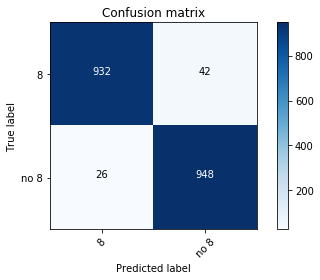

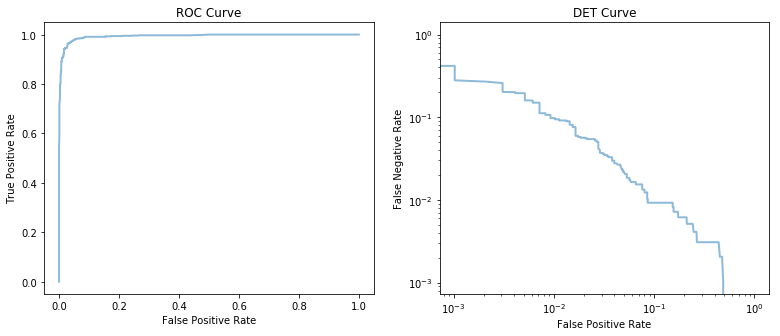

In [0]:
def confusion_matrix(labels, predictions):
    """Calcula la matriz de confusion.
    
    Args:
        labels: Array binario 1-D con las etiquetas reales.
        predictions: Array binario 1-D con las predicciones.
        
    Returns:
        TP: Numero de verdaderos positivos.
        FP: Numero de falsos positivos.
        FN: Numero de falsos negativos.
        TN: Numero de verdaderos negativos.
    """
    # Map labels and predictions to {0, 1, 2, 3}
    encoded_data = 2 * labels + predictions  
    TN = np.sum(encoded_data == 0)  # True negatives
    FP = np.sum(encoded_data == 1)  # False positives
    FN = np.sum(encoded_data == 2)  # False negatives
    TP = np.sum(encoded_data == 3)  # True positives
    return TP, FP, FN, TN


def performance_metrics(TP, FP, FN, TN):
    """Calcula metricas de desempeño.
    
    Args:
        TP: Numero de verdaderos positivos.
        FP: Numero de falsos positivos.
        FN: Numero de falsos negativos.
        TN: Numero de verdaderos negativos.
    
    Returns:
        accuracy: Porcentaje de clasificaciones correctas del detector.
        precision: Precision del detector.
        recall: Recall/Sensibilidad del detector.
    """
    accuracy = 100.0 * (TP + TN) / (TP + TN + FP + FN)
    precision = 100.0 * TP / (TP + FP)
    recall = 100.0 * TP / (TP + FN)
    print('TP: %d, TN: %d, FP: %d, FN: %d' %(TP,TN,FP,FN))
    print('%1.4f%% Accuracy (Porcentaje de clasificaciones correctas)' % (accuracy))
    print('%1.4f%% Precision' % (precision))
    print('%1.4f%% Recall' % (recall))
    print('')
    return accuracy, precision, recall


def roc_curve(labels, probabilities):
    """Calcula la curva ROC.
    
    Args:
        labels: Array binario 1-D con las etiquetas reales.
        probabilities: Array 1-D continuo en el rango [0, 1] con las
            probabilidades de la clase 1.
        
    Returns:
        tpr: Array 1-D con los valores de Tasa de Verdaderos Positivos (TPR).
        fpr: Array 1-D con los valores de Tasa de Falsos Positivos (FPR).
    """
    tpr = []
    fpr = []
    for threshold in np.linspace(0, 1, 1000):
        probabilities_with_threshold = (probabilities > threshold).astype(np.float)
        TP, FP, FN, TN = confusion_matrix(
            labels, 
            probabilities_with_threshold)
        tpr.append(TP/(TP+FN))
        fpr.append(FP/(FP+TN))
    return np.array(tpr), np.array(fpr)
  
  
def detection_performance_given_threshold(true_labels, prediction, threshold):
    probabilities_with_threshold = (prediction > threshold).astype(np.float)
    TP, FP, FN, TN = confusion_matrix(
        true_labels, 
        probabilities_with_threshold)    
    return TP, FP, FN, TN       

  
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid('off')
    plt.tight_layout()
    

predicted_train_labels = mlp.predict_label(training_images)
predicted_val_labels = mlp.predict_label(validation_images)
predicted_test_labels = mlp.predict_label(testing_images)

cnf_matrix = sk_conf_mat(testing_labels, predicted_test_labels)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['%d' % RUT_veri_number, 'no %d' % RUT_veri_number],
                      title='Confusion matrix')


print('Training results:')
TP, FP, FN, TN = confusion_matrix(training_labels, predicted_train_labels)
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

print('Validation results:')
TP, FP, FN, TN = confusion_matrix(validation_labels, predicted_val_labels)
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

print('Test results:')
TP, FP, FN, TN = confusion_matrix(testing_labels, predicted_test_labels)
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

predicted_test_proba = mlp.predict_proba(testing_images)
tpr, fpr = roc_curve(testing_labels, predicted_test_proba[:, 1])

fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].set_title('ROC Curve')
ax[0].plot(fpr, tpr, linewidth=2, alpha=0.5)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')

ax[1].set_title('DET Curve')
ax[1].plot(fpr, 1.0 - tpr, linewidth=2, alpha=0.5)
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('False Negative Rate')
ax[1].set_yscale('log')
ax[1].set_xscale('log')

### Performance según umbral de clasificación

In [0]:
predicted_validation_proba = mlp.predict_proba(validation_images)
threshold = 0.5
TP, FP, FN, TN = detection_performance_given_threshold(validation_labels, predicted_validation_proba[:, 1], threshold=threshold)
print('TP: %d, TN: %d, FP: %d, FN: %d' %(TP,TN,FP,FN))

TP: 445, TN: 445, FP: 17, FN: 17


### Visualización de clasificaciones en el test

True Positives:


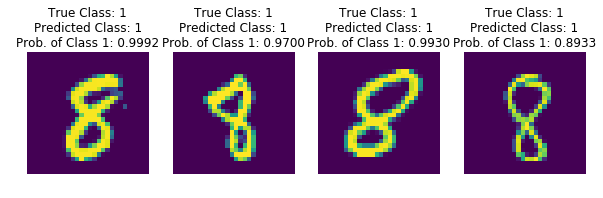

True Negatives:


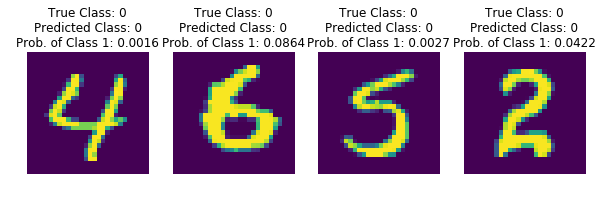

False Positive:


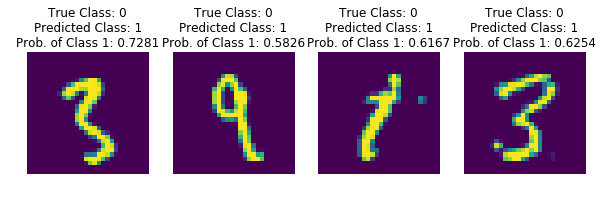

False Negative:


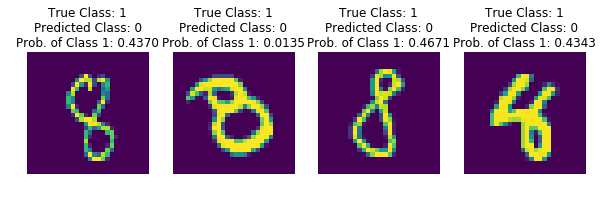

In [0]:
def show_classifications(images, labels, probabilities, result_type='TP'):
    """ Muestra ejemplos de imagenes para tipos de errores.
    
    Args:
        images: Array de dimensiones (n_ejemplos, n_pixeles) con imagenes.
        labels: Array de dimensiones (n_ejemplos,) con las etiquetas reales.
        probabilities: Array de dimensiones (n_ejemplos,) con las probabilidades
            de la clase 1.
        result_type: 'TP', 'FP', 'FN', o 'TP', tipo de error a mostrar.
    """
    dict_types = {'TN': 0, 'FP': 1, 'FN': 2, 'TP': 3}
    predictions = (probabilities > 0.5).astype(np.int32)
    encoded_data = 2 * labels + predictions 
    useful = np.where(encoded_data == dict_types[result_type])[0]
    size = min(4, useful.shape[0])
    chosen = np.random.choice(useful, size=size, replace=False)
    fig, ax = plt.subplots(1, 4, figsize=(10,4))
    for i, idx in enumerate(chosen):
        image = images[idx, :]
        digit = labels[idx]
        predicted_label = predictions[idx]
        proba = probabilities[idx]
        ax[i].imshow(image.reshape((28, 28)))
        ax[i].set_title("True Class: %d\nPredicted Class: %d\nProb. of Class 1: %1.4f"
                        % (digit, predicted_label, proba))
        ax[i].axis('off')
    for j in range(i+1, 4):
        ax[j].axis('off')
    plt.show()


predicted_test_proba = mlp.predict_proba(testing_images)
predicted_test_proba = predicted_test_proba[:, 1]

print('True Positives:')
show_classifications(testing_images, testing_labels, predicted_test_proba , result_type='TP')

print('True Negatives:')
show_classifications(testing_images, testing_labels, predicted_test_proba , result_type='TN')

print('False Positive:')
show_classifications(testing_images, testing_labels, predicted_test_proba , result_type='FP')

print('False Negative:')
show_classifications(testing_images, testing_labels, predicted_test_proba , result_type='FN')

## TensorBoard

In [0]:
# ----- Descarga de ngrok para crear tunel
%%bash
file="ngrok-stable-linux-amd64.zip"
if [ -f "$file" ]
then
	echo "$file already downloaded."
else
    wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    unzip ngrok-stable-linux-amd64.zip
fi

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


--2019-08-26 02:20:37--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.73.84.118, 54.165.51.142, 52.201.75.180, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.73.84.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607069 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

     0K .......... .......... .......... .......... ..........  0%  936K 14s
    50K .......... .......... .......... .......... ..........  0% 1.81M 11s
   100K .......... .......... .......... .......... ..........  1% 60.4M 7s
   150K .......... .......... .......... .......... ..........  1% 90.4M 5s
   200K .......... .......... .......... .......... ..........  1% 1.88M 6s
   250K .......... .......... .......... .......... ..........  2% 66.6M 5s
   300K .......... .......... .......... .......... ..........  2% 81.4M 4s
   350K .......... .......... .......... .......... ..........  

In [0]:
# ----- Ejecutar despues de nueva corrida para actualizar Tensorboard

LOG_DIR = logdir_father  # este es el logdir de nuestros summaries
print("Showing summaries at %s" % (LOG_DIR))

get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
print('Click URL to open TensorBoard:')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Showing summaries at ./tarea_1_logs/
Click URL to open TensorBoard:
https://f0131b01.ngrok.io


Si quieren borrar su log_dir, utilicen lo siguiente:

Ejecutar comandos en bash
* %%bash

para mirar lo que hay en el directorio actual:
* ls 

para borrar la carpeta "tarea_1_logs"
* rm -r tarea_1_logs

buscar procesos asociados a tensorboard
* ps aux | grep tensorboard

terminar un proceso
* kill -9 process_id (process_id es el pid del proceso)




In [0]:
%%bash
ls

ngrok
ngrok-stable-linux-amd64.zip
sample_data
tarea_1_logs


In [0]:
#!rm -r tarea_1_logs